In [55]:
# Do trạng thái thực thi bị reset, cần tải lại dữ liệu
import pandas as pd

# Đọc file CSV
file_path = "C:/Users/84967/Downloads/GIT CLONE HTTP/KPDL/Data/day.csv"

df = pd.read_csv(file_path)

# Hiển thị thông tin tổng quan về dữ liệu
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


(None,
    instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
 0        1  2011-01-01       1   0     1        0        6           0   
 1        2  2011-01-02       1   0     1        0        0           0   
 2        3  2011-01-03       1   0     1        0        1           1   
 3        4  2011-01-04       1   0     1        0        2           1   
 4        5  2011-01-05       1   0     1        0        3           1   
 
    weathersit      temp     atemp       hum  windspeed  casual  registered  \
 0           2  0.344167  0.363625  0.805833   0.160446     331         654   
 1           2  0.363478  0.353739  0.696087   0.248539     131         670   
 2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
 3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
 4           1  0.226957  0.229270  0.436957   0.186900      82        1518   
 
     cnt  
 0   985  
 1   801  
 2  1349  
 3  1562  
 4  1600  

Tiền xử lý hoàn tất! Dữ liệu đã sẵn sàng cho DBSCAN.


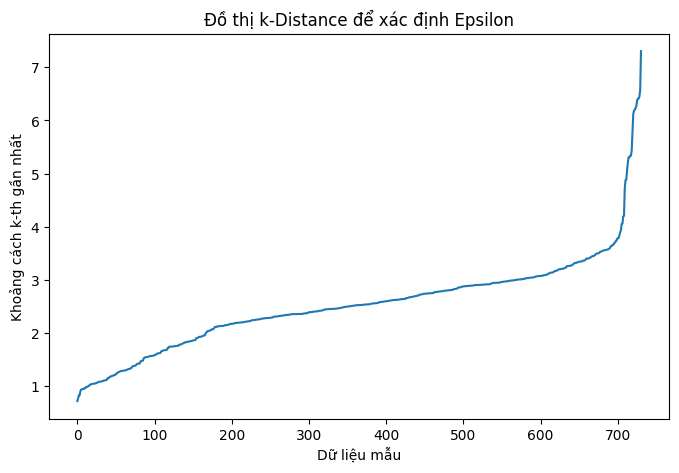

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors

# Giả sử biến df đã được load sẵn (ví dụ từ file "bike_hour.csv" hoặc "day.csv")

# Chọn các biến liên tục và phân loại
features_continuous = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['mnth', 'weathersit', 'season', 'weekday']

# Áp dụng One-Hot Encoding cho các biến phân loại
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(df[categorical_features])

# Tạo DataFrame cho các cột đã mã hóa
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Ghép lại với các cột liên tục
df_processed = pd.concat([df[features_continuous], encoded_df], axis=1)

# Chuẩn hóa dữ liệu bằng StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_processed)

# Xuất dữ liệu đã tiền xử lý ra file CSV
df_final = pd.DataFrame(df_scaled, columns=df_processed.columns)
df_final.to_csv("processed_bike_data.csv", index=False)
print("Tiền xử lý hoàn tất! Dữ liệu đã sẵn sàng cho DBSCAN.")

# Xác định tham số epsilon bằng đồ thị k-distance
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)

# Sắp xếp và vẽ đồ thị k-distance
distances = np.sort(distances[:, -1])
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Dữ liệu mẫu")
plt.ylabel("Khoảng cách k-th gần nhất")
plt.title("Đồ thị k-Distance để xác định Epsilon")
plt.show()

In [82]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Áp dụng DBSCAN với epsilon = 0.7 và min_samples = 5
epsilon = 3.5
dbscan = DBSCAN(eps=epsilon, min_samples=5)
df['cluster'] = dbscan.fit_predict(df_scaled)

# Kiểm tra số lượng cụm được tạo ra
num_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'].values else 0)

df_clean = df[df['cluster'] != -1]

# Tính Silhouette Score nếu có nhiều hơn một cụm hợp lệ
if num_clusters > 1:
    silhouette_avg = silhouette_score(df_scaled, df['cluster'])
else:
    silhouette_avg = None

num_clusters, silhouette_avg


(12, np.float64(0.30644382807742643))

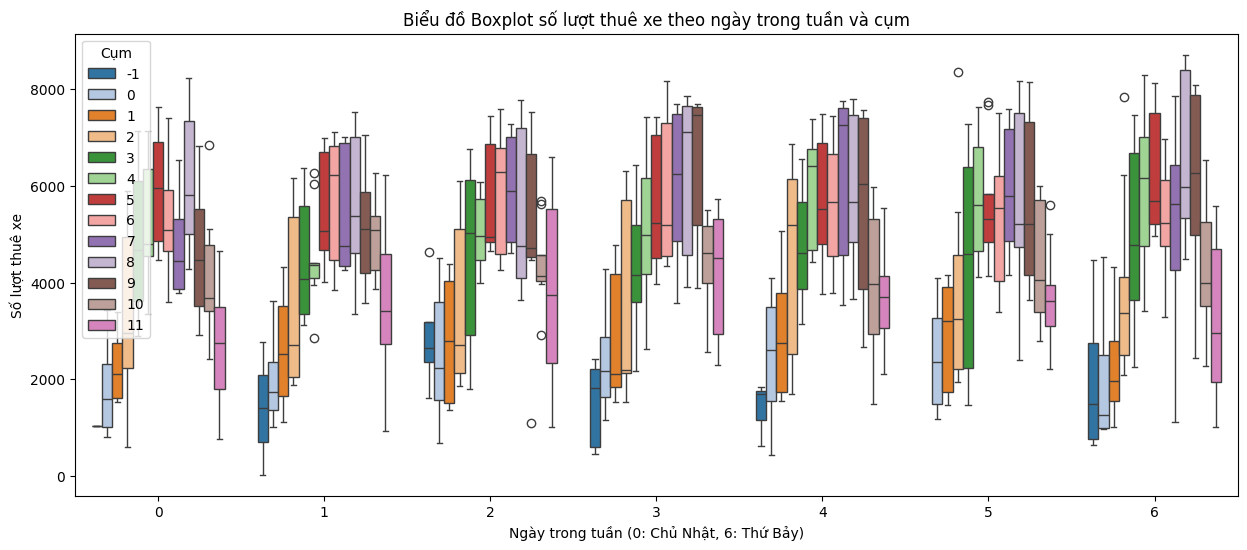

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
sns.boxplot(x='weekday', y='cnt', hue='cluster', data=df, palette='tab20')
plt.xlabel("Ngày trong tuần (0: Chủ Nhật, 6: Thứ Bảy)")
plt.ylabel("Số lượt thuê xe")
plt.title("Biểu đồ Boxplot số lượt thuê xe theo ngày trong tuần và cụm")
plt.legend(title="Cụm")
plt.show()


In [84]:
print(df['cluster'].unique()) 
print(df['cluster'].nunique()) 

[ 0 -1  1  2  3  4  5  6  7  8  9 10 11]
13
